# 2.0 Embeddings Construction

## Reading cleaned dataframes

In [1]:
import pandas as pd

users = pd.read_csv('../data/interim/users.csv')
movies = pd.read_csv('../data/interim/movies.csv')
ratings = pd.read_csv('../data/interim/ratings.csv')
occupations = pd.read_csv('../data/interim/occupations.csv')

## Constructing user embeddings

**Idea**: I am going to construct the user embeddings using simple One-Hot encoding. I will use the following columns: `gender`, `occupation`, `age`. I will also use the `user_id` column to be able to join the embeddings with the `films` and `ratings` dataframes.

`zip-code` column contains too many unique values and the distribution of the values is nearly uniform. Therefore, I will not use this column.

Also, `age` column has many different integers. To obtain more information, we can separate all users into 6 age bins:
- 0: 0-18
- 1: 18-25
- 2: 25-35
- 3: 35-45
- 4: 45-60
- 5: 60-75

Those clearly show the age groups that are most likely to watch movies.

In [2]:
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [3]:
gender_cols = ['genderF', 'genderM']
age_cols = ['age0_18', 'age18_25', 'age25_35', 'age35_45', 'age45_60', 'age60_75']

In [4]:
age_mappings = {
    0: [0, 18],
    1: [18, 25],
    2: [25, 35],
    3: [35, 45],
    4: [45, 60],
    5: [60, 75]
}

In [5]:
user_embeddings = pd.DataFrame()

In [6]:
user_embeddings['user_id'] = users['user_id']

In [7]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)

user_embeddings[gender_cols] = enc.fit_transform(users['gender'].to_numpy().reshape(-1, 1))
user_embeddings[occupations['occupation'].tolist()] = enc.fit_transform(users['occupation'].to_numpy().reshape(-1, 1))

In [8]:
# Splitting age column into 7 columns
user_embeddings[age_cols] = users['age'].apply(
    lambda x: pd.Series([1 if age_mappings[i][0] <= x < age_mappings[i][1] else 0 for i in range(6)]))

In [9]:
user_embeddings.head()

,user_id,genderF,genderM,administrator,artist,doctor,educator,engineer,entertainment,executive,...,scientist,student,technician,writer,age0_18,age18_25,age25_35,age35_45,age45_60,age60_75
0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,0,0,0,0
1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
2,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0,1,0,0,0,0
3,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,1,0,0,0,0
4,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,0


Here are our user embeddings, which contain all necessary information. Comparing to the original dataframe, we have 30 columns instead of 5.

In [10]:
user_embeddings.to_csv('../data/processed/user_embeddings.csv', index=False)

## Constructing movie embeddings

In [11]:
movies.head()

,item_id,title,action,adventure,animation,childrens,comedy,crime,documentary,drama,...,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western,release_year
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1995


Part of work is already done. The `genre` of the film is already one-hot encoded. For the `release_year` column I will also use bin splitting. Movie titles will be encoded using BERT embeddings.

In [12]:
year_cols = ['year0_1980', 'year1980_1990', 'year1990_1994', 'year1994', 'year1995', 'year1996',
             'year1997_2000']
year_mappings = {
    0: [0, 1980],
    1: [1980, 1990],
    2: [1990, 1994],
    3: [1994, 1995],
    4: [1995, 1996],
    5: [1996, 1997],
    6: [1997, 2000],
}

In [13]:
movie_embeddings = movies.copy()

In [14]:
movie_embeddings[year_cols] = movies['release_year'].apply(
    lambda x: pd.Series([1 if year_mappings[i][0] <= x < year_mappings[i][1] else 0 for i in range(7)]))
movie_embeddings.drop('release_year', axis=1, inplace=True)

In [15]:
movie_embeddings.head()

,item_id,title,action,adventure,animation,childrens,comedy,crime,documentary,drama,...,thriller,war,western,year0_1980,year1980_1990,year1990_1994,year1994,year1995,year1996,year1997_2000
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,GoldenEye (1995),1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,5,Copycat (1995),0,0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0


### Gettings embeddings for movie titles

In [16]:
movie_titles = movie_embeddings['title'].tolist()

In [17]:
from transformers import BertModel, BertTokenizer

model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
import torch


def bert_text_preparation(text, tokenizer):
    """
    Preprocesses text input in a way that BERT can interpret.
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(indexed_tokens)
    # convert inputs to tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensor = torch.tensor([segments_ids])
    return tokens_tensor, segments_tensor

In [19]:
def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens.
    """
    # gradient calculation id disabled
    with torch.no_grad():
        # obtain hidden states
        outputs = model(tokens_tensor, segments_tensor)
        hidden_states = outputs[2]
    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)
    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)
    # intialized list to store embeddings
    token_vecs_sum = []
    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence
    # loop over tokens in sentence
    for token in token_embeddings:
        # "token" is a [12 x 768] tensor
        # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    return token_vecs_sum

**Reference** for BERT inference code: [https://medium.com/mlearning-ai/getting-contextualized-word-embeddings-with-bert-20798d8b43a4](https://medium.com/mlearning-ai/getting-contextualized-word-embeddings-with-bert-20798d8b43a4)

In [20]:
bert_embeddings_list = [
    sum(get_bert_embeddings(*bert_text_preparation(title, tokenizer), model)).numpy()
    for title in movie_titles
]

In [21]:
bert_embeddings = pd.DataFrame(bert_embeddings_list, columns=[f'bert{i}' for i in range(768)])

In [22]:
bert_embeddings.head()

,bert0,bert1,bert2,bert3,bert4,bert5,bert6,bert7,bert8,bert9,...,bert758,bert759,bert760,bert761,bert762,bert763,bert764,bert765,bert766,bert767
0,-4.180209,-11.889176,-7.778333,-4.365942,9.808838,4.719962,-3.893777,-2.537226,-7.255859,7.506136,...,5.945799,-3.554621,-11.105366,-7.176516,-0.244159,0.192412,-0.906255,-2.131960,0.556587,-1.393222
1,-3.398317,-14.695908,-11.199031,5.201642,9.191294,7.452706,5.258362,-6.232143,-7.985827,2.406466,...,3.448807,-13.722857,-12.476220,-4.215858,-8.745135,6.873215,0.295823,-1.348131,1.119971,-0.225223
2,-1.495715,-9.434569,-6.097195,-0.242049,8.375702,11.414484,0.627479,-8.197442,-3.619811,4.742984,...,6.833307,-9.229140,-11.371151,-3.683799,-8.713809,-1.126313,-3.052222,-0.574684,-0.544990,-3.263015
3,-4.544728,-14.455235,-3.724633,5.628178,9.593926,2.865847,4.396505,1.870956,2.874588,11.305257,...,-4.315135,-12.236369,-12.858318,-6.657094,-6.173126,0.522330,-3.722292,-2.665669,-2.322573,-4.016519
4,-10.657256,-15.384276,6.282028,-3.847424,19.442572,-6.298932,-5.561044,6.848932,-1.736739,-0.673341,...,7.201597,-6.793350,-12.161377,-12.761230,-3.348340,3.210402,-3.444639,-3.967476,-1.728342,6.747972


In [23]:
movie_embeddings = pd.concat([movie_embeddings, bert_embeddings], axis=1)

In [24]:
movie_embeddings.drop('title', axis=1, inplace=True)

In [25]:
movie_embeddings.head()

,item_id,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,...,bert758,bert759,bert760,bert761,bert762,bert763,bert764,bert765,bert766,bert767
0,1,0,0,1,1,1,0,0,0,0,...,5.945799,-3.554621,-11.105366,-7.176516,-0.244159,0.192412,-0.906255,-2.131960,0.556587,-1.393222
1,2,1,1,0,0,0,0,0,0,0,...,3.448807,-13.722857,-12.476220,-4.215858,-8.745135,6.873215,0.295823,-1.348131,1.119971,-0.225223
2,3,0,0,0,0,0,0,0,0,0,...,6.833307,-9.229140,-11.371151,-3.683799,-8.713809,-1.126313,-3.052222,-0.574684,-0.544990,-3.263015
3,4,1,0,0,0,1,0,0,1,0,...,-4.315135,-12.236369,-12.858318,-6.657094,-6.173126,0.522330,-3.722292,-2.665669,-2.322573,-4.016519
4,5,0,0,0,0,0,1,0,1,0,...,7.201597,-6.793350,-12.161377,-12.761230,-3.348340,3.210402,-3.444639,-3.967476,-1.728342,6.747972


In [37]:
movie_embeddings.to_csv('../data/processed/movie_embeddings.csv', index=False)

## Joining embeddings with ratings

In [26]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [27]:
ratings_embeddings = ratings.merge(user_embeddings, on='user_id', how='left')
ratings_embeddings = ratings_embeddings.merge(movie_embeddings, on='item_id', how='left')

In [28]:
ratings_embeddings.drop(['user_id', 'item_id', 'timestamp'], axis=1, inplace=True)

In [29]:
ratings_embeddings.head()

,rating,genderF,genderM,administrator,artist,doctor,educator,engineer,entertainment,executive,...,bert758,bert759,bert760,bert761,bert762,bert763,bert764,bert765,bert766,bert767
0,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.251693,-13.530388,-10.312185,-6.998366,-9.448814,5.635257,-4.803998,-13.263495,-6.194516,2.764816
1,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.707056,-7.555910,-6.064219,-12.435462,-3.103521,-6.400305,-5.741024,4.378481,-0.204317,-10.159966
2,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.620211,-2.493063,2.810232,-0.291712,1.330938,-0.919351,1.201643,-3.051088,-8.859514,-11.834539
3,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.580922,-4.484633,-3.490076,-4.798437,-7.722100,12.472767,-5.917709,2.336888,-4.631447,-9.188141
4,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.257190,-9.879315,-9.244432,-2.753026,-5.583630,-2.354347,-1.422837,0.573999,-4.508924,0.035419


In [30]:
ratings_embeddings.to_csv('../data/processed/ratings_embeddings.csv', index=False)

## Splitting data into train and test for baseline model

In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings_embeddings, test_size=0.2, random_state=42, stratify=ratings_embeddings['rating'])

## Training baseline model

So, my idea is to train some model to predict the rating based on the user and movie embeddings. Then, I will recommend the movies with the highest predicted ratings to the user.

As baseline model I will use Decision Tree Classifier. It sounds reasonable to use it, because it is easy to interpret and it is not prone to overfitting.

In [38]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, max_depth=10)

clf.fit(train.drop('rating', axis=1), train['rating'])

DecisionTreeClassifier(max_depth=10, random_state=42)

In [39]:
clf.score(test.drop('rating', axis=1), test['rating'])

0.38043804380438045

In [48]:
from sklearn.metrics import classification_report

print(classification_report(test['rating'], clf.predict(test.drop('rating', axis=1))))

              precision    recall  f1-score   support

           1       0.37      0.09      0.15      1222
           2       0.28      0.02      0.04      2274
           3       0.34      0.37      0.36      5428
           4       0.39      0.65      0.48      6834
           5       0.46      0.23      0.31      4240

    accuracy                           0.38     19998
   macro avg       0.37      0.27      0.27     19998
weighted avg       0.38      0.38      0.34     19998



The Decision Tree shows bad performance in terms of precision/recall. Its F1 score is pretty good for ratings 3 and 4, as the support is bigger for them.

## Plotting tree

[Text(0.5, 0.9, 'year0_1980 <= 0.5\ngini = 0.748\nsamples = 79992\nvalue = [4886, 9096, 21714, 27336, 16960]'),
 Text(0.25, 0.7, 'drama <= 0.5\ngini = 0.752\nsamples = 66093\nvalue = [4589, 8216, 18687, 22094, 12507]'),
 Text(0.125, 0.5, 'year1980_1990 <= 0.5\ngini = 0.759\nsamples = 38670\nvalue = [3252, 5547, 11625, 12108, 6138]'),
 Text(0.0625, 0.3, 'bert372 <= -4.101\ngini = 0.76\nsamples = 32849\nvalue = [3018, 4984, 10119, 10026, 4702]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'bert724 <= 5.321\ngini = 0.733\nsamples = 5821\nvalue = [234, 563, 1506, 2082, 1436]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'bert419 <= -20.025\ngini = 0.735\nsamples = 27423\nvalue = [1337, 2669, 7062, 9986, 6369]'),
 Text(0.3125, 0.3, 'bert574 <= 17.421\ngini = 0.668\nsamples = 1488\nvalue = [39, 68, 221, 516, 644]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),

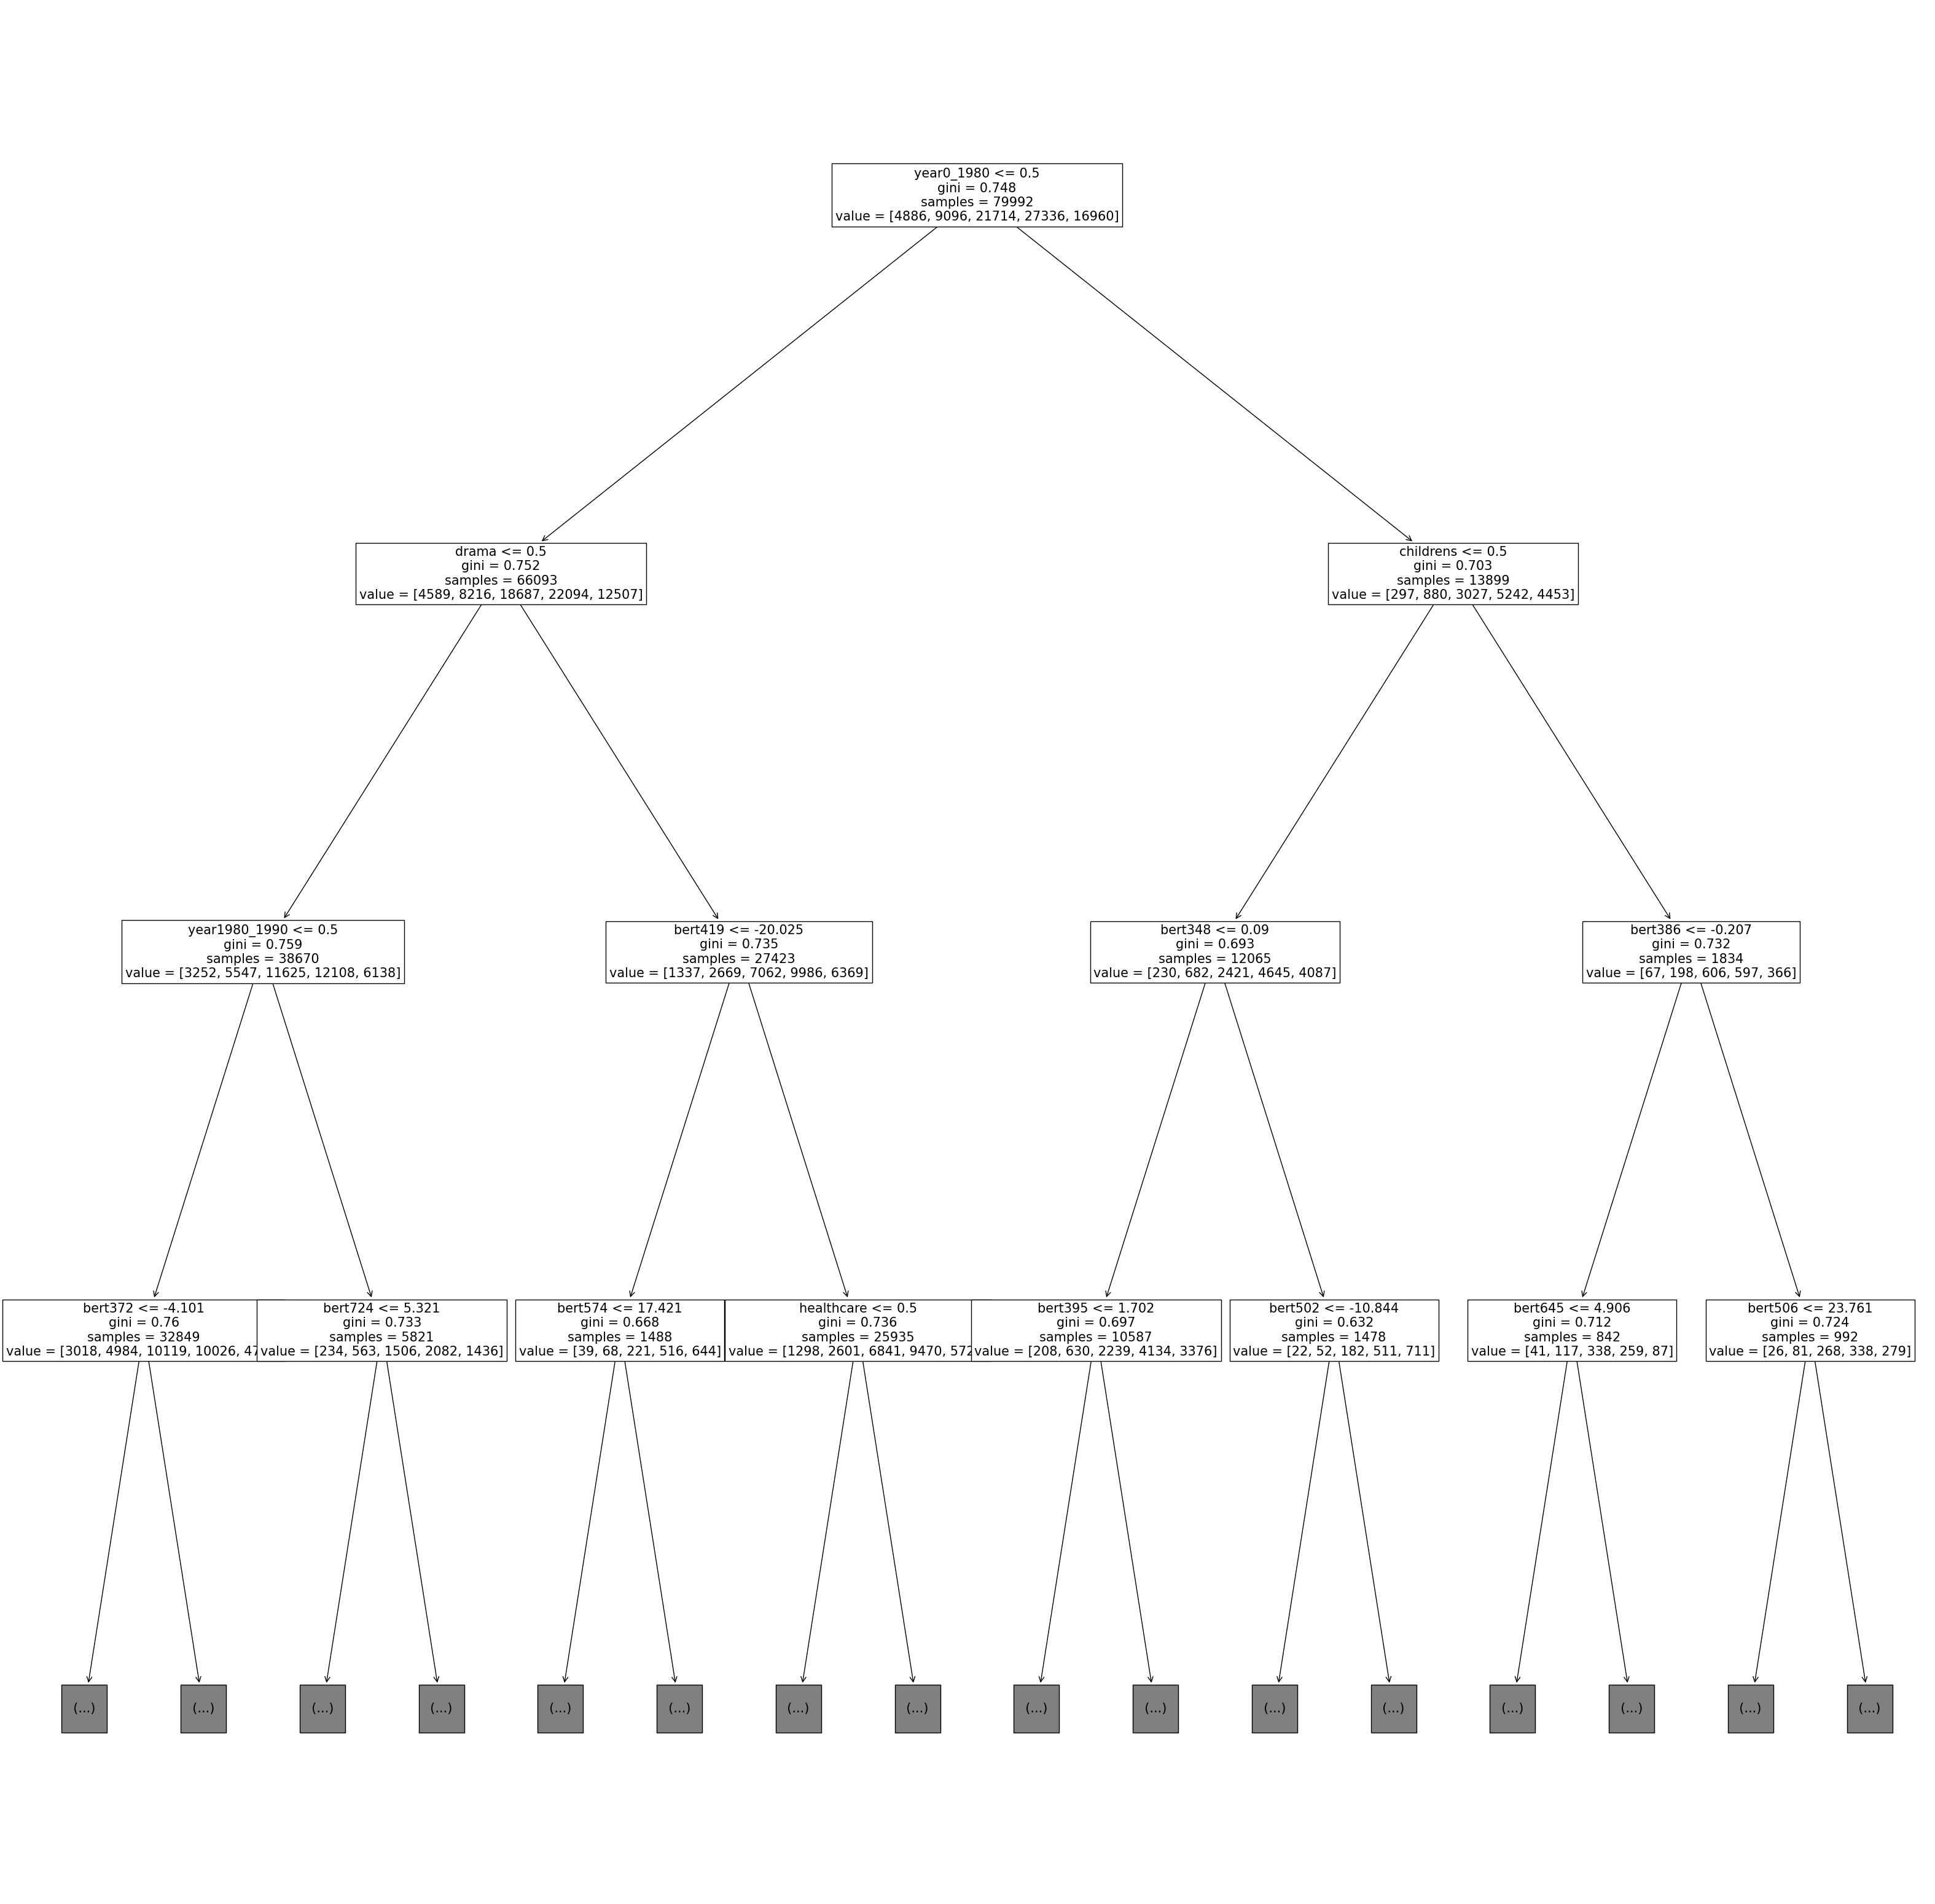

In [47]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
plot_tree(clf, feature_names=train.drop('rating', axis=1).columns, fontsize=15, max_depth=3)

From the **Tree Plot** we can see, that the model firstly tries to 'understand' the movie using Genre and Bert Embedding, and then the user to predict its' rating. It looks very logical!